## CommNet (NIPS 2016) – Results Notebook

This notebook **auto-discovers** training runs under `runs/` (created by `train.py`) and reproduces paper-aligned analysis plots:

- **Core comparisons**: learning curves (return) + success-rate curves (CommNet vs NoComm)
- **Communication analysis**: ablation over communication steps \(K\), and partial-observability stress tests (vision)

### What is being measured

- **Episode return**: sum of per-step rewards for an episode.
- **Success**: `info["success"]` from the **final step** of the episode when available, else 0.

### How this corresponds to the CommNet paper

- The paper commonly uses \(K=2\) for multi-turn tasks and compares **CommNet vs NoComm**.
- We reproduce those curves and add \(K\)-ablation + partial-observability sweeps.

### Differences from the paper (where applicable)

- These environments are lightweight educational implementations; reward details/dynamics may differ from the original MazeBase setups.
- Traffic Junction here uses a **fixed-slot** representation (`nmax` slots); `vision_range` changes the observation neighborhood size.


## Paper constants (reference)

These are **paper reference settings** (CommNet, NIPS 2016). We label them here for context; runs in this repo may deviate.

- **Lever game**: \(m=5\) active agents, pool \(N=500\), CommNet uses \(K=2\). Reward: \(#distinct levers\)/(#levers). Paper averages over 500 trials, trains 50,000 batches of size 64.
- **Multi-turn games (Traffic Junction, Combat)**: commonly \(K=2\), hidden size 50, horizon 40; report mean±std over 5 random initializations.
- **Traffic Junction (paper reference)**: 14×14 grid, 3×3 observation neighborhood, actions {gas, brake}, collision reward -10, time penalty -0.01·τ per car; failure if any collision.


In [38]:
from __future__ import annotations

import csv
import json
from dataclasses import dataclass
from pathlib import Path
from typing import Any

import numpy as np
import matplotlib.pyplot as plt

# Determinism (as much as notebooks allow)
np.random.seed(0)


def _find_repo_root(start: Path | None = None) -> Path:
    """Find repo root by walking up until we see train.py."""
    p = (start or Path.cwd()).resolve()
    for parent in [p, *p.parents]:
        if (parent / "train.py").exists():
            return parent
    # Fallback: assume current working directory is repo root.
    return p


REPO_ROOT = _find_repo_root()
RUNS_ROOT = REPO_ROOT / "runs"

# Smoothing windows (episodes)
RETURN_MA_WINDOW = 50
SUCCESS_ROLL_WINDOW = 50
FINAL_WINDOW = 200  # for bar-plot "final performance"

plt.rcParams.update(
    {
        "figure.dpi": 120,
        "axes.grid": True,
        "grid.alpha": 0.25,
        "axes.spines.top": False,
        "axes.spines.right": False,
    }
)


def _to_float(x: Any, default: float | None = None) -> float | None:
    try:
        return float(x)
    except Exception:
        return default


def _to_int(x: Any, default: int | None = None) -> int | None:
    try:
        return int(float(x))
    except Exception:
        return default


def moving_average_same(y: np.ndarray, window: int) -> np.ndarray:
    """Moving average with same-length output (pads initial values with NaN)."""
    y = np.asarray(y, dtype=np.float64)
    if window <= 1:
        return y
    if y.size == 0:
        return y
    w = int(window)
    kernel = np.ones((w,), dtype=np.float64) / float(w)
    valid = np.convolve(y, kernel, mode="valid")
    pad = np.full((w - 1,), np.nan, dtype=np.float64)
    return np.concatenate([pad, valid], axis=0)


def rolling_mean_same(y: np.ndarray, window: int) -> np.ndarray:
    return moving_average_same(y, window)


@dataclass
class Run:
    run_dir: Path
    env: str
    model: str  # commnet / nocomm
    seed: int
    K: int
    use_comm: bool
    vision_radius: float | None  # nav
    vision_range: int | None  # traffic
    visual_range: int | None  # combat
    episodes: np.ndarray
    returns: np.ndarray
    success: np.ndarray
    episode_len: np.ndarray

    @property
    def K_plot(self) -> int:
        return int(self.K) if self.use_comm else 0


def load_metrics_csv(path: Path) -> dict[str, np.ndarray]:
    with path.open(newline="", encoding="utf-8") as f:
        rows = list(csv.DictReader(f))

    def col(name: str) -> np.ndarray:
        return np.array([r.get(name, "") for r in rows])

    episode_idx = np.array([_to_int(v, 0) for v in col("episode_idx")], dtype=np.int64)
    episode_return = np.array(
        [_to_float(v, 0.0) for v in col("episode_return")], dtype=np.float64
    )
    success = np.array([_to_int(v, 0) for v in col("success")], dtype=np.int64)
    episode_len = np.array([_to_int(v, 0) for v in col("episode_len")], dtype=np.int64)

    return {
        "episode_idx": episode_idx,
        "episode_return": episode_return,
        "success": success,
        "episode_len": episode_len,
    }


def discover_runs(runs_root: Path = RUNS_ROOT) -> list[Run]:
    if not runs_root.exists():
        print(f"No runs found at {runs_root.resolve()}")
        return []

    runs: list[Run] = []
    for metrics_path in runs_root.rglob("metrics.csv"):
        run_dir = metrics_path.parent
        cfg_path = run_dir / "run_config.json"
        if not cfg_path.exists():
            continue

        try:
            cfg = json.loads(cfg_path.read_text(encoding="utf-8"))
        except Exception:
            continue

        env = str(cfg.get("env", run_dir.parents[1].name))
        model = str(cfg.get("model", run_dir.parent.name))
        seed = int(cfg.get("seed", -1))
        K = int(cfg.get("K", cfg.get("comm_steps", 0)))
        use_comm = bool(cfg.get("use_comm", model == "commnet"))

        nav_cfg = cfg.get("nav") or {}
        traffic_cfg = cfg.get("traffic") or {}
        combat_cfg = cfg.get("combat") or {}

        vision_radius = _to_float(nav_cfg.get("vision_radius"), None)
        vision_range = _to_int(traffic_cfg.get("vision_range"), None)
        visual_range = _to_int(combat_cfg.get("visual_range"), None)

        m = load_metrics_csv(metrics_path)
        runs.append(
            Run(
                run_dir=run_dir,
                env=env,
                model=model,
                seed=seed,
                K=K,
                use_comm=use_comm,
                vision_radius=vision_radius,
                vision_range=vision_range,
                visual_range=visual_range,
                episodes=m["episode_idx"],
                returns=m["episode_return"],
                success=m["success"],
                episode_len=m["episode_len"],
            )
        )

    # Stable ordering
    runs.sort(key=lambda r: (r.env, r.model, r.K_plot, r.seed, str(r.run_dir)))
    return runs


runs = discover_runs()
print(f"Discovered {len(runs)} runs")
if runs:
    print("Envs:", sorted(set(r.env for r in runs)))
    print("Models:", sorted(set(r.model for r in runs)))

Discovered 400 runs
Envs: ['combat', 'lever', 'nav', 'traffic']
Models: ['commnet', 'nocomm']


## A) Learning curves (CommNet vs NoComm)

For each environment, we plot **moving-average episode return** vs episode index.

- If multiple seeds exist, we plot **mean curve** with **±1 std** shading.
- By default, we prefer **CommNet runs with \(K=2\)** (paper-default) when available.


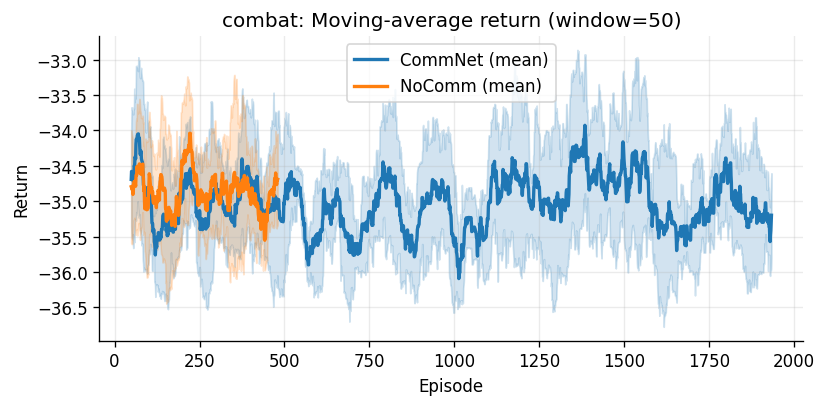

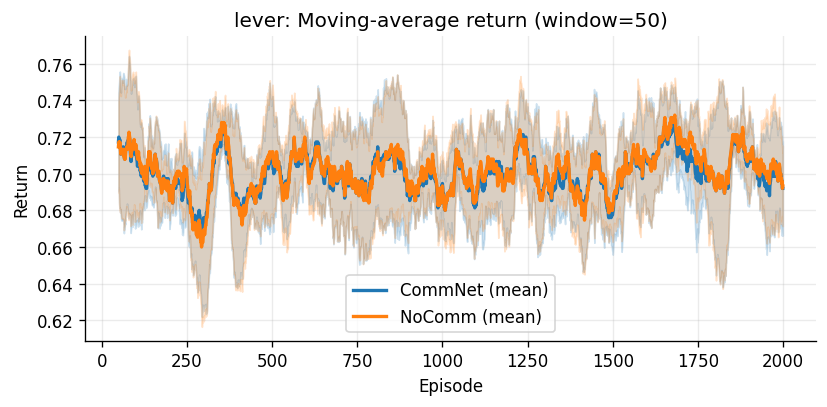

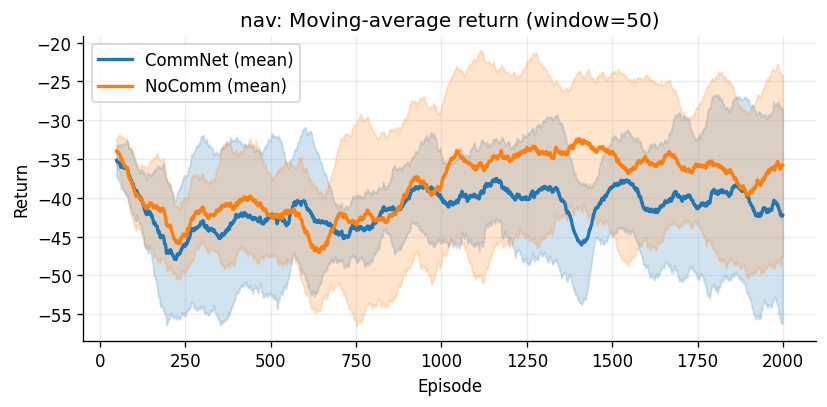

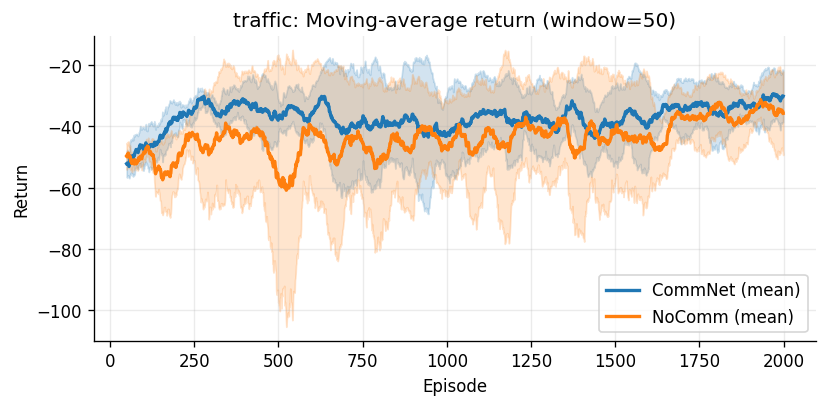

In [39]:
def _group_runs_by_seed(rs: list[Run]) -> dict[int, list[Run]]:
    out: dict[int, list[Run]] = {}
    for r in rs:
        out.setdefault(r.seed, []).append(r)
    return out


def _aggregate_curves(
    seqs: list[np.ndarray], window: int
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Return (x, mean, std) aggregated across sequences."""
    if not seqs:
        return np.array([]), np.array([]), np.array([])

    smoothed = [moving_average_same(s, window) for s in seqs]
    min_len = min(len(s) for s in smoothed)
    start = max(0, window - 1)
    if min_len <= start:
        return np.array([]), np.array([]), np.array([])

    stacked = np.stack([s[:min_len] for s in smoothed], axis=0)[:, start:]
    mean = np.nanmean(stacked, axis=0)
    std = np.nanstd(stacked, axis=0)
    x = np.arange(start, start + mean.size)
    return x, mean, std


def _select_core_env_runs(env: str, all_runs: list[Run]) -> tuple[list[Run], list[Run]]:
    comm = [r for r in all_runs if r.env == env and r.model == "commnet"]
    nocomm = [r for r in all_runs if r.env == env and r.model == "nocomm"]

    # Prefer paper-default K=2 for CommNet if available
    comm_k2 = [r for r in comm if r.K_plot == 2]
    if comm_k2:
        comm = comm_k2
    return comm, nocomm


envs = sorted(set(r.env for r in runs))
for env in envs:
    comm_runs, nocomm_runs = _select_core_env_runs(env, runs)
    if not comm_runs and not nocomm_runs:
        continue

    fig, ax = plt.subplots(figsize=(7.0, 3.5))

    for label, rs, color in [
        ("CommNet", comm_runs, "C0"),
        ("NoComm", nocomm_runs, "C1"),
    ]:
        # If multiple runs exist for same (env, model, seed), keep the latest by path sort.
        by_seed = _group_runs_by_seed(rs)
        per_seed = []
        for seed, seed_runs in sorted(by_seed.items()):
            seed_runs.sort(key=lambda r: str(r.run_dir))
            per_seed.append(seed_runs[-1].returns)

        x, mean, std = _aggregate_curves(per_seed, RETURN_MA_WINDOW)
        if x.size == 0:
            continue
        ax.plot(x, mean, label=f"{label} (mean)", color=color, linewidth=2)
        if len(per_seed) >= 2:
            ax.fill_between(x, mean - std, mean + std, color=color, alpha=0.2)

    ax.set_title(f"{env}: Moving-average return (window={RETURN_MA_WINDOW})")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Return")
    ax.legend()
    ax.grid(True, alpha=0.25)
    fig.tight_layout()
    plt.show()

## B) Success-rate curves (CommNet vs NoComm)

For each environment, we plot **rolling success rate** vs episode index.

- Success is pulled from the final-step `info["success"]`.
- If multiple seeds exist, we plot **mean ± std** across seeds.


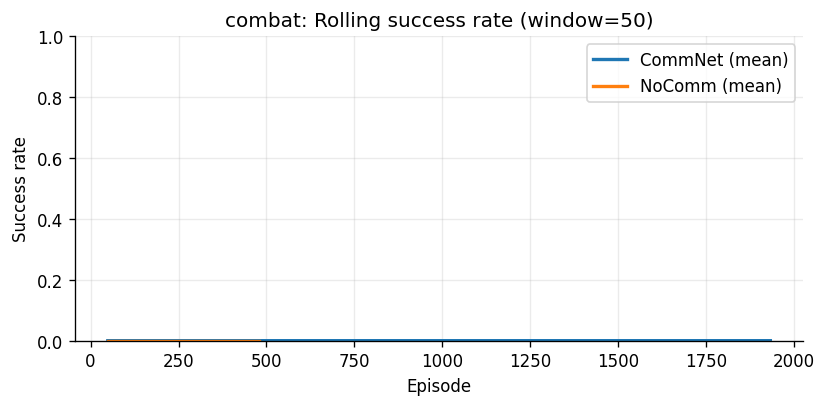

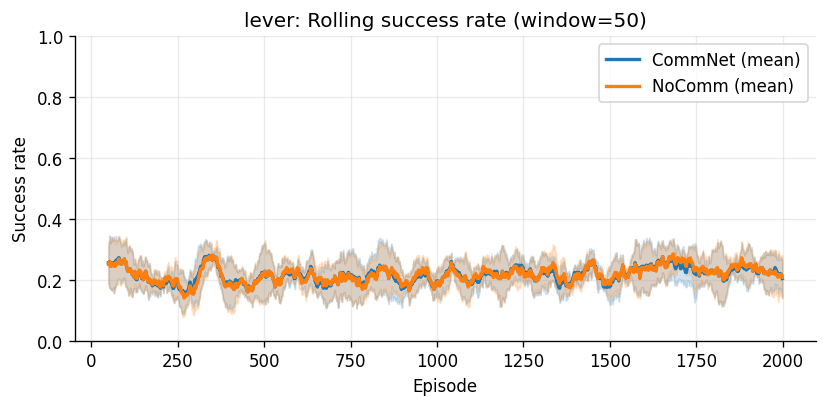

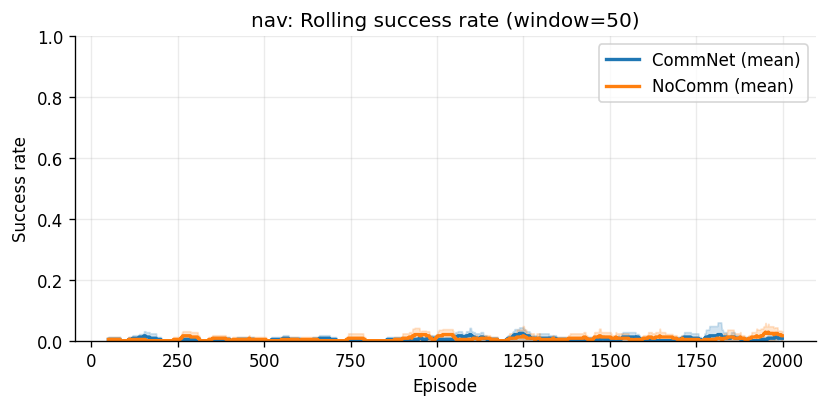

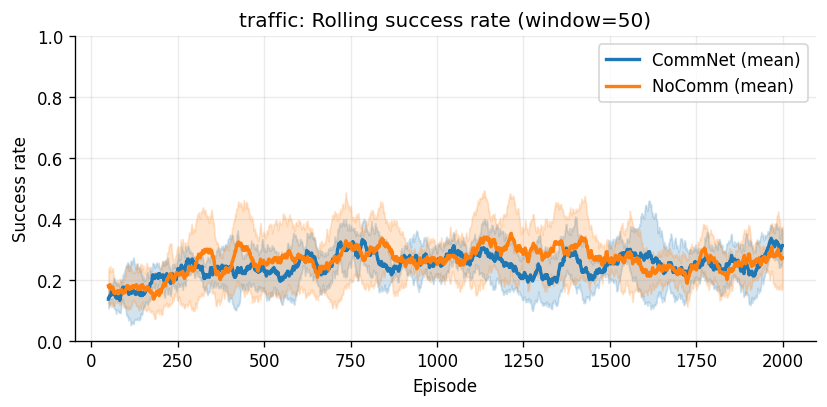

In [40]:
def _aggregate_success(
    seqs: list[np.ndarray], window: int
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    if not seqs:
        return np.array([]), np.array([]), np.array([])
    smoothed = [rolling_mean_same(s.astype(np.float64), window) for s in seqs]
    min_len = min(len(s) for s in smoothed)
    start = max(0, window - 1)
    if min_len <= start:
        return np.array([]), np.array([]), np.array([])

    stacked = np.stack([s[:min_len] for s in smoothed], axis=0)[:, start:]
    mean = np.nanmean(stacked, axis=0)
    std = np.nanstd(stacked, axis=0)
    x = np.arange(start, start + mean.size)
    return x, mean, std


envs = sorted(set(r.env for r in runs))
for env in envs:
    comm_runs, nocomm_runs = _select_core_env_runs(env, runs)
    if not comm_runs and not nocomm_runs:
        continue

    fig, ax = plt.subplots(figsize=(7.0, 3.5))

    for label, rs, color in [
        ("CommNet", comm_runs, "C0"),
        ("NoComm", nocomm_runs, "C1"),
    ]:
        by_seed = _group_runs_by_seed(rs)
        per_seed = []
        for seed, seed_runs in sorted(by_seed.items()):
            seed_runs.sort(key=lambda r: str(r.run_dir))
            per_seed.append(seed_runs[-1].success)

        x, mean, std = _aggregate_success(per_seed, SUCCESS_ROLL_WINDOW)
        if x.size == 0:
            continue
        ax.plot(x, mean, label=f"{label} (mean)", color=color, linewidth=2)
        if len(per_seed) >= 2:
            ax.fill_between(
                x,
                np.clip(mean - std, 0.0, 1.0),
                np.clip(mean + std, 0.0, 1.0),
                color=color,
                alpha=0.2,
            )

    ax.set_title(f"{env}: Rolling success rate (window={SUCCESS_ROLL_WINDOW})")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Success rate")
    ax.set_ylim(0.0, 1.0)
    ax.legend()
    ax.grid(True, alpha=0.25)
    fig.tight_layout()
    plt.show()

## C) \(K\)-ablation (communication steps)

For selected environments (at least **nav** and **traffic**), we overlay curves for \(K \in \{0,1,2,3\}\) **when those runs exist**.

- Return curves: moving-average return.
- Success curves: rolling success rate.

Note: here we plot **CommNet runs** for different \(K\). The **NoComm baseline** is shown separately (dashed).


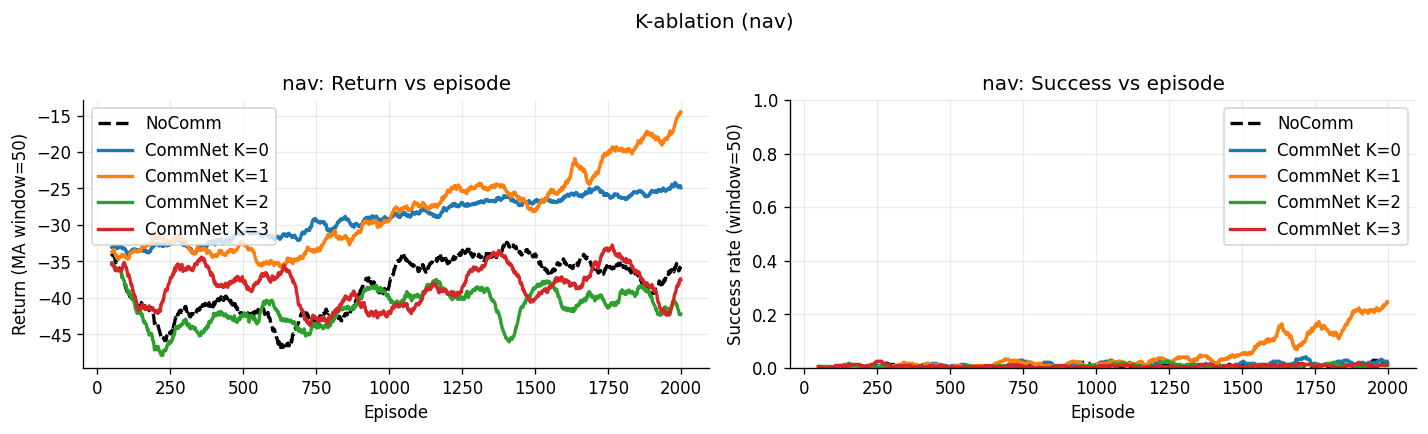

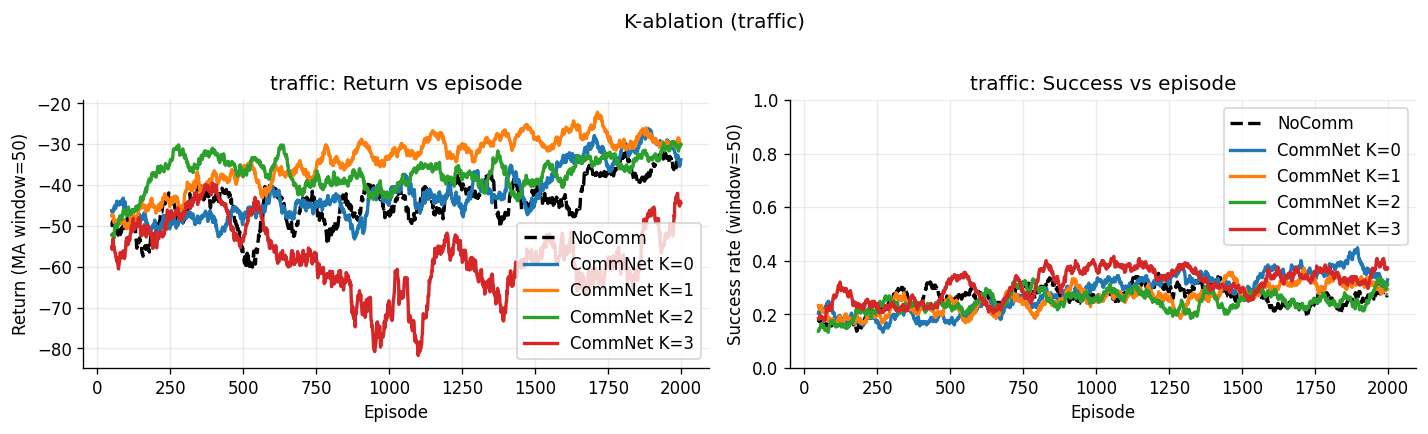

In [41]:
def _latest_per_seed(rs: list[Run]) -> list[Run]:
    by_seed = _group_runs_by_seed(rs)
    out = []
    for seed, seed_runs in sorted(by_seed.items()):
        seed_runs.sort(key=lambda r: str(r.run_dir))
        out.append(seed_runs[-1])
    return out


def plot_k_ablation(env: str, K_values: list[int] | None = None) -> None:
    comm = [r for r in runs if r.env == env and r.model == "commnet"]
    base = [r for r in runs if r.env == env and r.model == "nocomm"]

    if K_values is None:
        K_values = [0, 1, 2, 3]

    fig, (ax_r, ax_s) = plt.subplots(1, 2, figsize=(12.0, 3.5), sharex=False)

    # NoComm baseline
    if base:
        base_latest = _latest_per_seed(base)
        x, mean, std = _aggregate_curves(
            [r.returns for r in base_latest], RETURN_MA_WINDOW
        )
        if x.size:
            ax_r.plot(x, mean, color="k", linestyle="--", linewidth=2, label="NoComm")
        x, mean, std = _aggregate_success(
            [r.success for r in base_latest], SUCCESS_ROLL_WINDOW
        )
        if x.size:
            ax_s.plot(x, mean, color="k", linestyle="--", linewidth=2, label="NoComm")

    # CommNet by K
    for K in K_values:
        rs = [r for r in comm if r.K_plot == K]
        if not rs:
            continue
        latest = _latest_per_seed(rs)

        x, mean, std = _aggregate_curves([r.returns for r in latest], RETURN_MA_WINDOW)
        if x.size:
            ax_r.plot(x, mean, linewidth=2, label=f"CommNet K={K}")

        x, mean, std = _aggregate_success(
            [r.success for r in latest], SUCCESS_ROLL_WINDOW
        )
        if x.size:
            ax_s.plot(x, mean, linewidth=2, label=f"CommNet K={K}")

    ax_r.set_title(f"{env}: Return vs episode")
    ax_r.set_xlabel("Episode")
    ax_r.set_ylabel(f"Return (MA window={RETURN_MA_WINDOW})")
    ax_r.grid(True, alpha=0.25)
    ax_r.legend()

    ax_s.set_title(f"{env}: Success vs episode")
    ax_s.set_xlabel("Episode")
    ax_s.set_ylabel(f"Success rate (window={SUCCESS_ROLL_WINDOW})")
    ax_s.set_ylim(0.0, 1.0)
    ax_s.grid(True, alpha=0.25)
    ax_s.legend()

    fig.suptitle(f"K-ablation ({env})", y=1.02)
    fig.tight_layout()
    plt.show()


for env in [e for e in ["nav", "traffic"] if e in set(r.env for r in runs)]:
    plot_k_ablation(env, K_values=[0, 1, 2, 3])

## D) Partial observability stress test (vision)

We vary the observation range and compare **final performance** (mean over last `FINAL_WINDOW` episodes) between CommNet and NoComm.

- **Nav**: uses `vision_radius`.
- **Traffic**: uses `vision_range`.

If multiple seeds exist, bars show **mean** with **std** error bars.


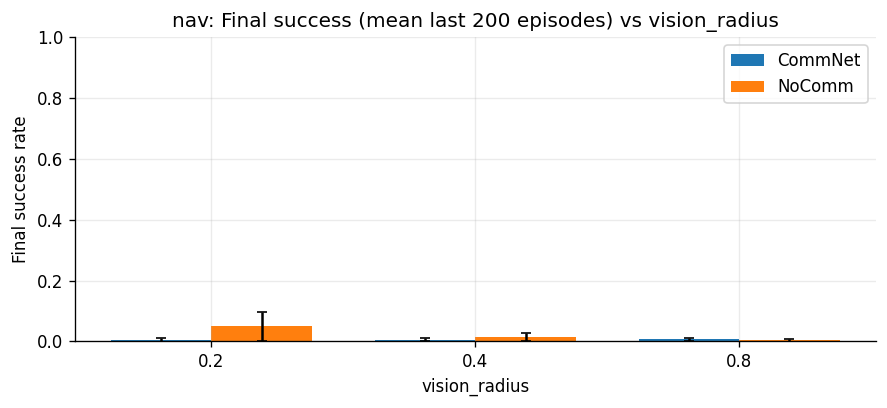

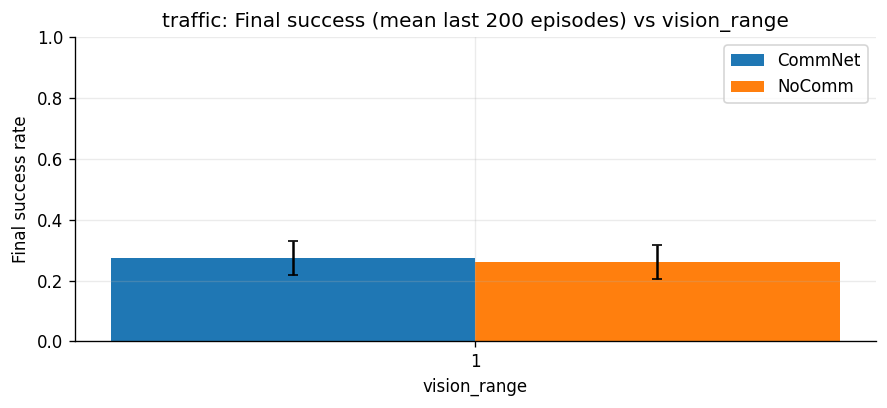

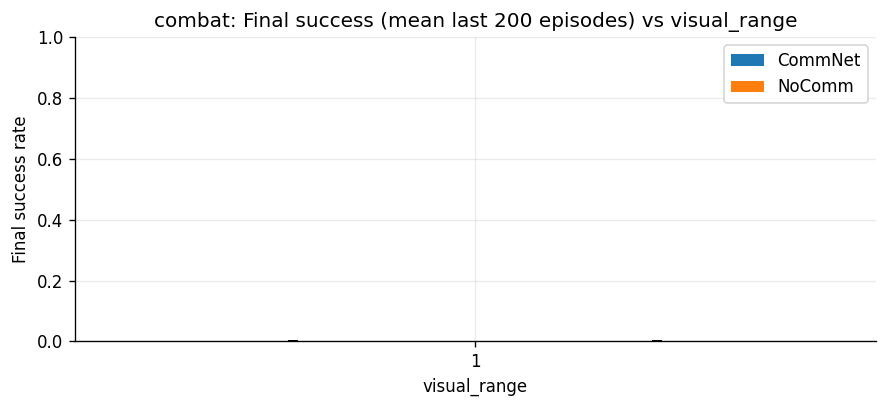

Lever game: no vision parameter (single-step coordination game with agent IDs only)
Found 90 lever runs (no vision stress test applicable)


In [ ]:
def _final_mean(x: np.ndarray, window: int) -> float:
    x = np.asarray(x, dtype=np.float64)
    if x.size == 0:
        return float("nan")
    w = min(int(window), x.size)
    return float(np.mean(x[-w:]))


def _final_summary(rs: list[Run]) -> tuple[float, float]:
    """Return (mean, std) of final success over seeds."""
    latest = _latest_per_seed(rs)
    vals = np.array(
        [_final_mean(r.success, FINAL_WINDOW) for r in latest], dtype=np.float64
    )
    if vals.size == 0:
        return float("nan"), float("nan")
    if vals.size == 1:
        return float(vals[0]), 0.0
    return float(np.mean(vals)), float(np.std(vals))


def plot_vision_bars_nav() -> None:
    nav_runs = [r for r in runs if r.env == "nav"]
    if not nav_runs:
        return

    settings = sorted(
        {r.vision_radius for r in nav_runs if r.vision_radius is not None}
    )
    if not settings:
        print("No nav vision_radius found in run configs")
        return

    comm_all = [r for r in nav_runs if r.model == "commnet"]
    nocomm_all = [r for r in nav_runs if r.model == "nocomm"]

    # Prefer K=2 commnet runs when available
    comm_k2 = [r for r in comm_all if r.K_plot == 2]
    if comm_k2:
        comm_all = comm_k2

    comm_means, comm_stds = [], []
    base_means, base_stds = [], []

    for v in settings:
        comm_v = [r for r in comm_all if r.vision_radius == v]
        base_v = [r for r in nocomm_all if r.vision_radius == v]
        m, s = _final_summary(comm_v)
        comm_means.append(m)
        comm_stds.append(s)
        m, s = _final_summary(base_v)
        base_means.append(m)
        base_stds.append(s)

    x = np.arange(len(settings))
    width = 0.38

    fig, ax = plt.subplots(figsize=(7.5, 3.5))
    ax.bar(x - width / 2, comm_means, width, yerr=comm_stds, capsize=3, label="CommNet")
    ax.bar(x + width / 2, base_means, width, yerr=base_stds, capsize=3, label="NoComm")

    ax.set_title(
        f"nav: Final success (mean last {FINAL_WINDOW} episodes) vs vision_radius"
    )
    ax.set_xlabel("vision_radius")
    ax.set_ylabel("Final success rate")
    ax.set_xticks(x, [f"{v:g}" for v in settings])
    ax.set_ylim(0.0, 1.0)
    ax.legend()
    ax.grid(True, alpha=0.25)
    fig.tight_layout()
    plt.show()


def plot_vision_bars_traffic() -> None:
    tr_runs = [r for r in runs if r.env == "traffic"]
    if not tr_runs:
        return

    settings = sorted({r.vision_range for r in tr_runs if r.vision_range is not None})
    if not settings:
        print("No traffic vision_range found in run configs")
        return

    comm_all = [r for r in tr_runs if r.model == "commnet"]
    nocomm_all = [r for r in tr_runs if r.model == "nocomm"]

    # Prefer K=2 commnet runs when available
    comm_k2 = [r for r in comm_all if r.K_plot == 2]
    if comm_k2:
        comm_all = comm_k2

    comm_means, comm_stds = [], []
    base_means, base_stds = [], []

    for vr in settings:
        comm_v = [r for r in comm_all if r.vision_range == vr]
        base_v = [r for r in nocomm_all if r.vision_range == vr]
        m, s = _final_summary(comm_v)
        comm_means.append(m)
        comm_stds.append(s)
        m, s = _final_summary(base_v)
        base_means.append(m)
        base_stds.append(s)

    x = np.arange(len(settings))
    width = 0.38

    fig, ax = plt.subplots(figsize=(7.5, 3.5))
    ax.bar(x - width / 2, comm_means, width, yerr=comm_stds, capsize=3, label="CommNet")
    ax.bar(x + width / 2, base_means, width, yerr=base_stds, capsize=3, label="NoComm")

    ax.set_title(
        f"traffic: Final success (mean last {FINAL_WINDOW} episodes) vs vision_range"
    )
    ax.set_xlabel("vision_range")
    ax.set_ylabel("Final success rate")
    ax.set_xticks(x, [str(vr) for vr in settings])
    ax.set_ylim(0.0, 1.0)
    ax.legend()
    ax.grid(True, alpha=0.25)
    fig.tight_layout()
    plt.show()


def plot_vision_bars_combat() -> None:
    combat_runs = [r for r in runs if r.env == "combat"]
    if not combat_runs:
        return

    settings = sorted(
        {r.visual_range for r in combat_runs if r.visual_range is not None}
    )
    if not settings:
        print("No combat visual_range found in run configs")
        return

    comm_all = [r for r in combat_runs if r.model == "commnet"]
    nocomm_all = [r for r in combat_runs if r.model == "nocomm"]

    # Prefer K=2 commnet runs when available
    comm_k2 = [r for r in comm_all if r.K_plot == 2]
    if comm_k2:
        comm_all = comm_k2

    comm_means, comm_stds = [], []
    base_means, base_stds = [], []

    for vr in settings:
        comm_v = [r for r in comm_all if r.visual_range == vr]
        base_v = [r for r in nocomm_all if r.visual_range == vr]
        m, s = _final_summary(comm_v)
        comm_means.append(m)
        comm_stds.append(s)
        m, s = _final_summary(base_v)
        base_means.append(m)
        base_stds.append(s)

    x = np.arange(len(settings))
    width = 0.38

    fig, ax = plt.subplots(figsize=(7.5, 3.5))
    ax.bar(x - width / 2, comm_means, width, yerr=comm_stds, capsize=3, label="CommNet")
    ax.bar(x + width / 2, base_means, width, yerr=base_stds, capsize=3, label="NoComm")

    ax.set_title(
        f"combat: Final success (mean last {FINAL_WINDOW} episodes) vs visual_range"
    )
    ax.set_xlabel("visual_range")
    ax.set_ylabel("Final success rate")
    ax.set_xticks(x, [str(vr) for vr in settings])
    ax.set_ylim(0.0, 1.0)
    ax.legend()
    ax.grid(True, alpha=0.25)
    fig.tight_layout()
    plt.show()


# Plot vision bars for all environments
plot_vision_bars_nav()
plot_vision_bars_traffic()
plot_vision_bars_combat()

## Generating runs for these plots

This notebook discovers whatever exists under `runs/`. To generate paper-style runs:

- **Core comparison (paper-default \(K=2\), 5 seeds)**:

```bash
python train.py --env nav --comm_steps 2 --seeds 0,1,2,3,4
python train.py --env traffic --comm_steps 2 --seeds 0,1,2,3,4
```

- **K-ablation** (example for nav):

```bash
for K in 0 1 2 3; do
  python train.py --env nav --comm_steps $K --seeds 0,1,2,3,4
done
```

- **Partial observability sweeps** (examples):

```bash
# nav vision_radius sweep
for v in 0.2 0.4 0.8; do
  python train.py --env nav --vision $v --comm_steps 2 --seeds 0,1,2,3,4
done

# traffic vision_range sweep
for vr in 1 2 3; do
  python train.py --env traffic --vision_range $vr --comm_steps 2 --seeds 0,1,2,3,4
done
```

If you don’t have all these runs yet, the notebook will **infer available settings** and plot what it finds.
